In [1]:
import argparse
import os
import warnings
import yaml
import sys
sys.path.append('/home/pasti/PycharmProjects/Robot_CLOD/')

import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.accelerators import find_usable_cuda_devices
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from nanodet.data.collate import naive_collate
from nanodet.data.dataset import build_dataset
from nanodet.evaluator import build_evaluator
from nanodet.trainer.task import TrainingTask
from nanodet.trainer.latent_dist_task import LatentDistTrainingTask
from torchvision.transforms import ToTensor, ToPILImage
from nanodet.util import (
    NanoDetLightningLogger,
    cfg,
    convert_old_model,
    env_utils,
    load_config,
    load_model_weight,
    mkdir,
)


load_config(cfg, '../cfg/cluttertask1.yml')
train_dataset = build_dataset(cfg.data.train, "train")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=cfg.device.workers_per_gpu,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=True,
)

val_dataset = build_dataset(cfg.data.val, "val")

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=cfg.device.workers_per_gpu,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=False,
)
evaluator = build_evaluator(cfg.evaluator, val_dataset)

TrainTask = TrainingTask(cfg, evaluator)

FileNotFoundError: [Errno 2] No such file or directory: '../cfg/cluttertask1.yml'

['paper_cutter_04/frame0094.jpg']


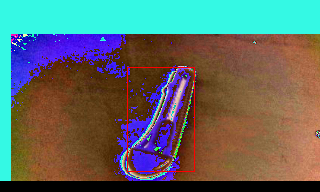

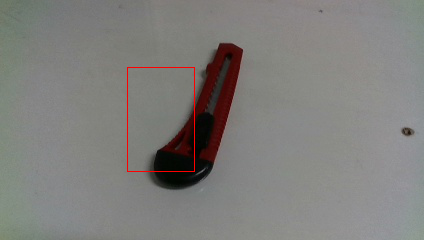

In [7]:
from IPython.display import display
from PIL import ImageDraw
from PIL import Image

for batch in train_dataloader:
    batch = TrainTask._preprocess_batch_input(batch)
    i = 0
    print(batch['img_info']['file_name'])
    for img in batch['img']:
        imgPil = ToPILImage()(batch['img'][i])

        imgPath = '/home/pasti/Dataset/openLORIS/images1/train/clutter/segment1/' + str(batch['img_info']['file_name'][i])
        imgPath = Image.open(imgPath)
        draw = ImageDraw.Draw(imgPil)
        drawOrig = ImageDraw.Draw(imgPath)

        for box in batch['gt_bboxes'][i]:
            draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')
            drawOrig.rectangle([box[0], box[1], box[2], box[3]], outline='red')
        display(imgPil)
        display(imgPath)
        
        i += 1
    break

# MAYBE NEED TO FIX THE DATA AUGMENTATION PART (?)

In [12]:
img = batch["img"]

### STUDENT NETWORK ###

feat = TrainTask.model.backbone(img)
fpn_feat = TrainTask.model.fpn(feat)
head_out = TrainTask.model.head(fpn_feat)

print(f"head_out shape: {head_out.shape}")

def tensor_memory(tensor):
    # Get number of elements in the tensor
    num_elements = tensor.numel()

    # Get size of each element in bytes
    if tensor.dtype == torch.float32:  # float32: 4 bytes
        element_size = 4
    elif tensor.dtype == torch.float64:  # float64: 8 bytes
        element_size = 8
    elif tensor.dtype == torch.int64:  # int64: 8 bytes
        element_size = 8
    elif tensor.dtype == torch.int32:  # int32: 4 bytes
        element_size = 4
    elif tensor.dtype == torch.uint8:  # uint8: 1 byte
        element_size = 1
    else:
        raise ValueError(f"Unsupported data type: {tensor.dtype}")

    # Compute total memory size in bytes
    memory_size = num_elements * element_size

    return memory_size

memory_size = tensor_memory(head_out)
print(f"Memory size of head_out: {memory_size} bytes")


head_out shape: torch.Size([1, 1275, 36])
Memory size of head_out: 183600 bytes
